# <center>CITS5508 Final Project: Classifiying on MNIST Fashion dataset</center>

**Name: Ruan Scheepers**<br>
**Student number: 21980258**<br>
**Date created:** May 1st 2019<br>
**Last modified:** May 24th 2019<br>

Below is the required imports and the plot function for the confusion matrix.

In [1]:
# Common imports
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot the figures for visualisation
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


def plot_confusion_matrix(matrix, labels):
    
    print(labels)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    

    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    cax = ax.matshow(matrix, cmap=plt.cm.gray)
    
    ax.set(xticks=np.arange(matrix.shape[1]),
       yticks=np.arange(matrix.shape[0]),
       xticklabels=labels, 
       yticklabels=labels,
       title='Confustion Matrix',
       ylabel='True',
       xlabel='Predicted')

    fig.colorbar(cax)

    
    thresh = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, format(matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if matrix[i, j] < thresh else "black")
    fig.tight_layout()

## Load Data

Loading the data from "fashion-mnist_(test/train).csv" and defining two functions to show the image for the corresponding pixels. These will be used to compare images in the Autoencoder. Since the data is already split into test and training data (that is evenly distributed over all labels) the data is ready to be used.

In [3]:
import pandas as pd

## functions to retrieve the two data sets
def load_testing():
    csv_path = os.path.join("fashion-mnist_test.csv")
    return pd.read_csv(csv_path)

def load_training():
    csv_path = os.path.join("fashion-mnist_train.csv")
    return pd.read_csv(csv_path)

In [4]:
training_data = load_training() ##load the training data
training_data.head() ##confirm the load was successful and view the columns

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
testing_data = load_testing()
testing_data.head()##confirm the load was successful and view the columns

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def plot_image(data):
    image = data.values.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    plt.show()

In [7]:
def plot_image_from_array(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
train_features = training_data.copy()
test_features = testing_data.copy()

In [9]:
train_features = train_features.drop("label", axis = 1)
test_features = test_features.drop("label", axis = 1)

train_labels = training_data["label"];
test_labels = testing_data["label"];

In [10]:
some_image = train_features.loc[1:5,:]

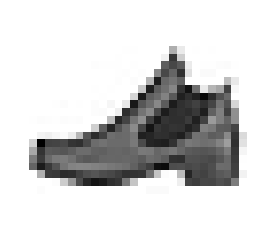

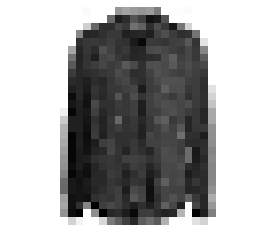

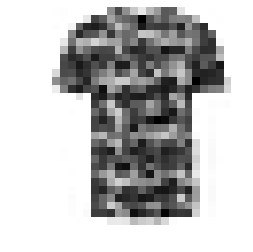

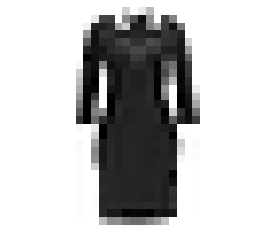

In [11]:
for i in range(1,5):
    plot_image(some_image.loc[i,:]) #Test the plot_image function.

In [12]:
training_data["label"].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

## Performance Measure

The performance will be measure in the following ways: 

Accuracy: How often the predicted label matches the true label.

F1_score: This is a better measure of accuracy as it incorporates false positives and false negatives. It's a 'weighted average' between precision and recall. Note it does reward models that have similar precision and recall (sometimes the context demands cases where we prefer precision or recall and willing to make a tradeoff).

Confusion Matrices: Finally we will be analysing the confusion matrices, this shows the true labels and misslables of the model, it can highlight a particular class being prone to misslabeling ect.

## Multi-layer perceptron.

Training the MLP classifier I started with a basic 1 hidden layer with 250 neurons. A single hidden layer can often work for complex situations. For this first model, I also used the `Adam Optimizer` with "1e-4" as a random starting point. With the rest as the defaults.(Relu activation) This scored f1 score of about 77%.

The DNNClassifier calculates <b> Loss </b> by using softmax cross entropy.

Then for some fine tuning I tried the following hyperparamater fields. For the choice of hidden layers, the first choice is to check the performance of a single layer. The second of the 'stretch pants' philosophy and the third the 'funnel' philosophy.

Optimizers: Adam Optimizer and AdaGrad Optimizer

Hidden Layers: [250], [250,250], [1024, 512, 256]

Dropout: None or 0.1

Below is the winning selection.

In [61]:
#scale the input and prepare the column keys

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(train_features)
X_test_standard = scaler.transform(test_features)

feature_cols = [tf.feature_column.numeric_column(key='image',shape=(784,))]


input_fn_train=tf.estimator.inputs.numpy_input_fn(
    x=dict({'image':X_train_standard}),
    y=train_labels.values,
    shuffle=True)

C:\Users\schee\.conda\envs\mlenvTensor\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schee\.conda\envs\mlenvTensor\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\schee\.conda\envs\mlenvTensor\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  import sys


In [62]:

print("You can retrain the whole model or retrieve one that has already trained on 100000 steps, below it will train just 1 more step from a checkpoint to show the training is functional, it will load from a current checkpoint. Press 'n' to use the existing model")
answer = input("Retraining the MLP model (y/n)? ")



if answer == "y":
# train the MLP using the training set
    mlp_clf = tf.estimator.DNNClassifier(
        feature_columns=feature_cols,
        hidden_units=[1024, 512, 256],
        optimizer=tf.train.AdamOptimizer(1e-4),
        n_classes=10,
        model_dir="./Scheepers_Ruan_files/mlp_clf2_model" #making a new directory so it does not overide the other model incase it needs to be assessed.
    )  
    mlp_clf.train(input_fn=input_fn_train, steps=50000)

else:
# restore the model
    mlp_clf = tf.estimator.DNNClassifier(
        feature_columns=feature_cols,
        hidden_units=[1024, 512, 256],
        optimizer=tf.train.AdamOptimizer(1e-4),
        n_classes=10,
        model_dir="./Scheepers_Ruan_files/mlp_clf_model" # points to the already trained model
    )  
    


You can retrain the whole model or retrieve one that has already trained on 100000 steps, below it will train just 1 more step from a checkpoint to show the training is functional, it will load from a current checkpoint. Press 'n' to use the existing model
Retraining the MLP model (y/n)? n
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './Scheepers_Ruan_files/mlp_clf_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020ABA500128>, '_t

The tf.estimator class automatically saves checkpoints at the start, and end of training. Any subsequent calls to the estimators 'Predict', 'Train' or 'Evaluate' function uses the will automatically restore from the latest checkpoint (if given the path like we did above.) Below is just an example of how we would manually restore the the paramaters. 

In [63]:
print("Path to the latest checkpoint for the chosed model above : ")
print(mlp_clf.latest_checkpoint())

print("\n Manually loading paramaters from a saved model : \n")

new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    new_saver = tf.train.import_meta_graph('./Scheepers_Ruan_files/mlp_clf_model/model.ckpt-938.meta')
    new_saver.restore(sess, "./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-938")
    

Path to the latest checkpoint for the chosed model above : 
./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-939

 Manually loading paramaters from a saved model : 

INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-938


In [65]:
## WILL train a few more step starting from the previous checkpoint to show that training is functional

mlp_clf.train(input_fn_train, steps=500)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-1408
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1408 into ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt.
INFO:tensorflow:loss = 23.530819, step = 1409
INFO:tensorflow:global_step/sec: 52.3043
INFO:tensorflow:loss = 31.881264, step = 1509 (1.913 sec)
INFO:tensorflow:global_step/sec: 57.4273
INFO:tensorflow:loss = 35.778435, step = 1609 (1.741 sec)
INFO:tensorflow:global_step/sec: 58.8424
INFO:tensorflow:loss = 30.891426, step = 1709 (1.700 sec)
INFO:tensorflow:global_step/sec: 54.7611
INFO:tensorflow:loss = 29.516483, step = 1809 (1.825 sec)
INFO:tensorflow:Saving checkpoints for 1877 into ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt.
INFO:tensorflow:Loss for final

In [66]:
# Evaluate accuracy

input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x=dict({'image':X_test_standard}),
    y=test_labels,
    num_epochs=1,
    shuffle=False)


eval_testData = mlp_clf.evaluate(input_fn=input_fn_test)
accuracy = eval_testData["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy*100))



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-26T07:24:54Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-1877
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-26-07:24:55
INFO:tensorflow:Saving dict for global step 1877: accuracy = 0.8915, average_loss = 0.2913599, global_step = 1877, loss = 36.881
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1877: ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-1877

Test Accuracy: 89.150000%



In [18]:
predicted = mlp_clf.predict(input_fn_test)
predictions = [p['class_ids'][0] for p in predicted]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_clf_model\model.ckpt-939
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [19]:
matrix_test = confusion_matrix(list(test_labels), predictions)

f1 score macro : 0.8837392345835793
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


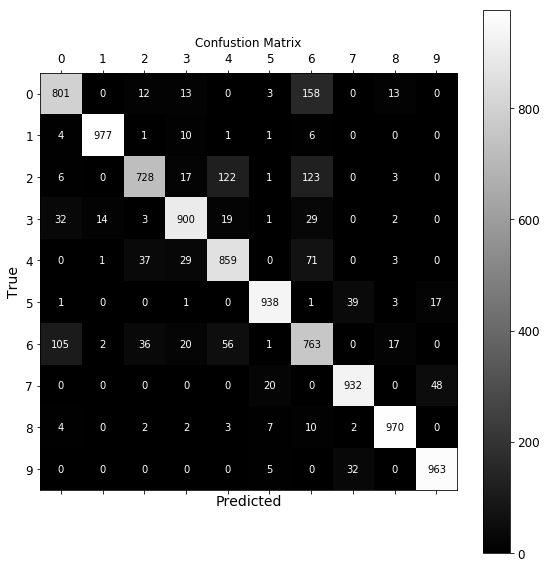

In [22]:
print("f1 score macro :",f1_score(test_labels, predictions, average='macro'))
plot_confusion_matrix(matrix_test, ["0","1","2","3","4","5","6","7","8","9"])

## Autoencoder

Neural networks can take a long time training, especially having so many hyperparamaters to tune. This autoencoder below will be used to reduce the dimensionality of our 784 features down to 150.

I will be making a stacked autoencoder with the following structure:
***
<p> Input &rarr; Hidden Layer1 (300 units) &rarr; Hidden Layer 2 <b> The codings layer </b> (150 units) &rarr; Hidden Layer 3 (300 units) &rarr; Output </p>

***

Since the encoder is symmetrical the weights of the 'decoder' can be tied to the weights of the encoder. This will reduce the training time (less weights) and reduce the risk of overfitting.

For the activation function I will use the ELU activation function. This should help with any cases of the vanishing/exploding gradient problems.

The "He initializer" will be used.


We will be adding a 'l2' regularlizing term to the loss function to prevent overfitting. Finally the autoencoder will use the Adam Optimizer to minimize our loss. 


In [23]:
## A function that reconstructs the images using the decoder. Used to compare the original photo to the decoded photo.
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 4):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)  ## Restore the paramaters from the saved model.
        X_test = x_test[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image_from_array(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image_from_array(outputs_val[digit_index])

In [24]:
#The stacked layer structure.
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # the codings layer, Reducing down to 150 features.
n_hidden3 = n_hidden1
n_outputs = n_inputs


# Turns the data into numpy.ndarray type for below
x_train = train_features.values
x_test = test_features.values

# Prepare input 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


#Prepare the paramaters
learning_rate = 0.01
l2_reg = 0.0005

#Prepare the ELU activation function
activation = tf.nn.elu

#The He-initializer NOTE:The contrib has a predefined He-initialiser, the text book noted below as an alternative.
initializer = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))

#Placeholder for the input
X = tf.placeholder(tf.float32, shape=[None, n_inputs])


#I used the weights below as a 'random' initialiser to compare the the HE-intialiser and the He-intializer out performed the random significantly.

#weights1_init = tf.Variable(tf.random_normal([n_inputs, n_hidden1])) 
#weights2_init = tf.Variable(tf.random_normal([n_hidden1, n_hidden2]))

#Set up the weights and biases, NOTE the weights 3,4 are tied.
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

#prepare the hidden layers.
hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

#Get the regularisation loss and add it to our cost function.
reg_loss = tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2)
loss = tf.reduce_mean(reconstruction_loss + l2_reg * reg_loss) #loss uses both the reconstruction loss and our l2 regularisation

#finally set up the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

## Train the Autoencoder 

In [25]:
saver = tf.train.Saver()

n_epochs = 5
batch_size = 100

#with 5 epochs takes about 20 seconds
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        ##Calculate the number of batches and run the training data through the encoder.
        n_batches= int(x_train.shape[0]/batch_size) 
        for i in range(n_batches):
            print("\r{}%".format(100 * i // n_batches), end="")
            epoch_input = x_train[ i * batch_size : (i + 1) * batch_size ]
            sess.run(training_op, feed_dict={X: epoch_input})
        loss_train = reconstruction_loss.eval(feed_dict={X: epoch_input})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./Scheepers_Ruan_files/auto.ckpt")  ## SAVE THE MODEL 
        

0 Train MSE: 0.020729747
1 Train MSE: 0.020821728
29% Train MSE: 0.021207415
3 Train MSE: 0.021534739
4 Train MSE: 0.022068366


INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/auto.ckpt


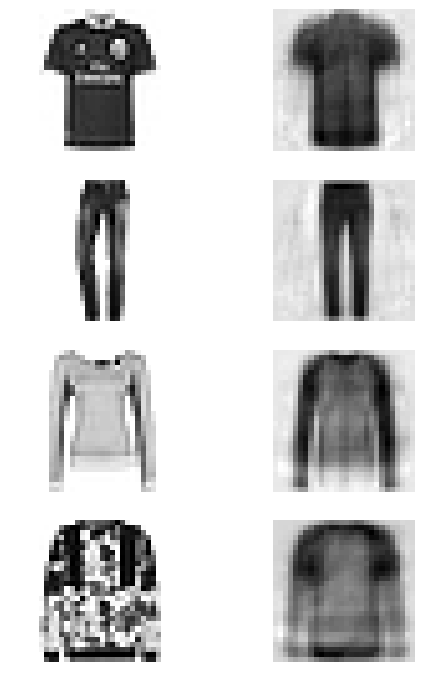

In [26]:
show_reconstructed_digits(X, outputs, "./Scheepers_Ruan_files/auto.ckpt")

## Autoencoder used with MLP

In [27]:
## Ready the data 


x_train = train_features.values
x_test = test_features.values


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Reduce Features

The function below loads the autoencoder from the given path, and converts the data to appropriate 'layer' so to encode the data we will pass 'hidden2'.

So the training features will be reduced and the above model will be retrained on the new set. The training time was significantly reduced and performance shown below.

In [28]:
def reduce_features(X, outputs, features, model_path = None):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = features
        outputs_val = outputs.eval(feed_dict={X: X_test})
    return outputs_val

In [29]:
train_reduced = reduce_features(X, hidden2, x_train, "./Scheepers_Ruan_files/auto.ckpt")

INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/auto.ckpt


In [30]:
feature_column = [tf.feature_column.numeric_column(key='image',shape=(150,))]
mlp_clf_auto = tf.estimator.DNNClassifier(
    feature_columns = feature_column,
    hidden_units=[1024, 512, 256],
    optimizer=tf.train.AdamOptimizer(1e-4),
    n_classes=10,
    model_dir="./Scheepers_Ruan_files/mlp_auto_clf_model"
)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './Scheepers_Ruan_files/mlp_auto_clf_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020ABB11D0B8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [31]:
input_fun_reduced=tf.estimator.inputs.numpy_input_fn(
    dict({'image':train_reduced}),
    train_labels.values,
    shuffle=False)

In [34]:
mlp_clf_auto.train(input_fn=input_fun_reduced, steps=50000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_auto_clf_model\model.ckpt-1876
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1876 into ./Scheepers_Ruan_files/mlp_auto_clf_model\model.ckpt.
INFO:tensorflow:loss = 71.08154, step = 1877
INFO:tensorflow:global_step/sec: 38.4314
INFO:tensorflow:loss = 71.89924, step = 1977 (2.604 sec)
INFO:tensorflow:global_step/sec: 45.868
INFO:tensorflow:loss = 71.679085, step = 2077 (2.182 sec)
INFO:tensorflow:global_step/sec: 45.9311
INFO:tensorflow:loss = 46.985672, step = 2177 (2.175 sec)
INFO:tensorflow:global_step/sec: 47.4751
INFO:tensorflow:loss = 34.441227, step = 2277 (2.105 sec)
INFO:tensorflow:Saving checkpoints for 2345 into ./Scheepers_Ruan_files/mlp_auto_clf_model\model.ckpt.
Instructions for u

In [35]:
# Evaluate accuracy
test_reduced = reduce_features(X, hidden2, x_test, "./Scheepers_Ruan_files/auto.ckpt")
test_reduced_input_fn=tf.estimator.inputs.numpy_input_fn(
    dict({'image':test_reduced}),
    test_labels.values,
    shuffle=False)

eval_testData = mlp_clf_auto.evaluate(input_fn=test_reduced_input_fn)
accuracy = eval_testData["accuracy"]
print("\nTest Accuracy: {0:f}%\n".format(accuracy*100))



INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/auto.ckpt
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-26T05:26:03Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_auto_clf_model\model.ckpt-2345
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-26-05:26:05
INFO:tensorflow:Saving dict for global step 2345: accuracy = 0.8383, average_loss = 0.44769415, global_step = 2345, loss = 56.670143
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2345: ./Scheepers_Ruan_files/mlp_auto_clf_model\model.ckpt-2345

Test Accuracy: 83.829999%



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/mlp_auto_clf_model\model.ckpt-2345
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
f1 score macro : 0.8356738223360765
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


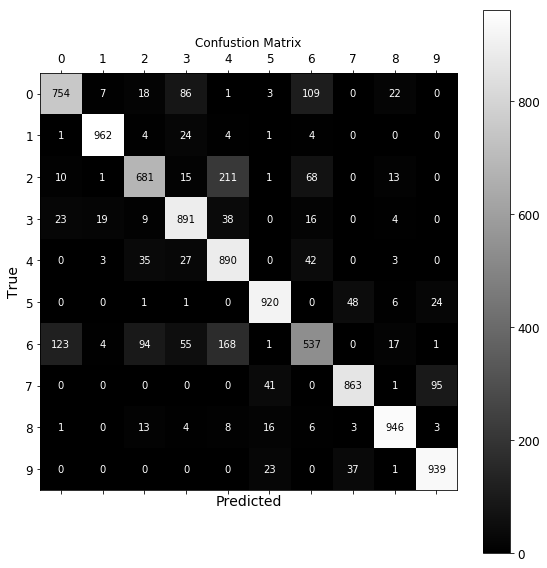

In [36]:
predicted = mlp_clf_auto.predict(test_reduced_input_fn)
predictions = [p['class_ids'][0] for p in predicted]

matrix_test = confusion_matrix(list(test_labels), predictions)
print("f1 score macro :",f1_score(test_labels, predictions, average='macro'))
plot_confusion_matrix(matrix_test, ["0","1","2","3","4","5","6","7","8","9"])

## Analysis

The above MLP model (same hyper paramaters as section 1) with the autoencoder performed slightly worse, but was trained signficantly faster. This will allow for a far greater search in the hyperparamater space. 

Sometimes a reduction in features can improve the performace as it focuses on the more important features and reduces ovefitting. In particular the first autoencoder I ran on the MLP model with hidden layer of [250] the f1_score was improved from 76 to 79. 

## CNN

The next section will train a convolutional neural network. 

I trained two different structures. 

First was motivated from the tutorial https://www.tensorflow.org/tutorials/estimators/cnn

Which had:
***
| Layer         | Kernel Size | Avtivation |
|---------------|-------------|------------|
| Dense Layer   |      _      |    ReLU    |
| Max Pooling 2 |     2x2     |            |
| Convolution 2 |     5x5     |    ReLU    |
| Max Pooling 1 |     2x2     |            |
| Convolution 1 |     5x5     |    ReLU    |
| Input         |             |            |

***

The second drew inspiration from the LeNet-5 architecture.

| Layer         | Kernel Size | Avtivation |
|---------------|-------------|------------|
| Dense Layer   |      _      |    ReLU    |
| Convolution 3 |     5x5     |    tanh    |
| Avg Pooling 2 |     2x2     |            |
| Convolution 2 |     5x5     |    tanh    |
| Avg Pooling 1 |     2x2     |            |
| Convolution 1 |     5x5     |    tanh    |
| Input         |             |            |

***

Below is the result of the best perfoming Model.

tf.layers was used to make the pooling and convolution layer. This will be depreciated in future updates and will me moved to tf.keras. I used the tf.layers since contrib and keras was not allowed for this project. (so the warnings can be ignored)

***

The first model out perfomed the second, but to deviate from the model I will add a third convolution layer to it.

So The 2 pooling layers will use the Max Pooling. The three convultion layers will use Relu activation.

The loss function used will be softmax cross entropy.


In [60]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

## Prepare the cnn_model_fn to be used with Estimator class.
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    #uses relu activation 
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # Max pooling 
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    
    #The third Convolution layer with relu activation and 128 filters.
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=128, 
        kernel_size=[5, 5],
        padding="same",
    activation=tf.nn.relu)
    
    # Dense Layer 
    conv3_flat = tf.reshape(conv3, [-1, 7 * 7 * 128])
    dense = tf.layers.dense(inputs=conv3_flat, units=1024, activation=tf.nn.relu) 
    
    #Include dropout regularisation.
    
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [54]:
x_train = train_features.values
x_test = test_features.values
scaler = StandardScaler()
# Prepare input
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [55]:
tensors_to_log = {"probabilities": "softmax_tensor"}
    
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

# The input function used to train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_train},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)


In [56]:
print("You can retrain the whole model or retrieve one that has already trained on 20000 steps, below it will train just 1 more to show the training is functional, it will load from a current checkpoint. Press 'n' to use old model")
answer = input("Retraining the CNN model (y/n)? ")
if answer == "y":
# train the CNN using the training set
    cnn_classifier = tf.estimator.Estimator(
        model_fn=cnn_model_fn, model_dir="./Scheepers_Ruan_files/cnn_model")
    
    # train the model for 20000 steps, WARNING TAKES A LONG TIME
    cnn_classifier.train(
        input_fn=train_input_fn,
        steps=20000,
        hooks=[logging_hook])
else:
# restore the model
    cnn_classifier = tf.estimator.Estimator(
        model_fn=cnn_model_fn, model_dir="./Scheepers_Ruan_files/cnn_2")

You can retrain the whole model or retrieve one that has already trained on 20000 steps, below it will train just 1 more to show the training is functional, it will load from a current checkpoint. Press 'n' to use old model
Retraining the CNN model (y/n)? n
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './Scheepers_Ruan_files/cnn_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020ABBD2D470>, '_task_type': 'worker', '_task_id': 0, '_glo

In [57]:
## WILL train 1 more step starting from the previous checkpoint to show that training is functional

cnn_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/cnn_2\model.ckpt-26001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 26001 into ./Scheepers_Ruan_files/cnn_2\model.ckpt.
INFO:tensorflow:probabilities = [[0.00044303 0.00000664 0.47256744 0.00002645 0.3846177  0.00000839
  0.14211488 0.00000002 0.00020464 0.00001093]
 [0.03345996 0.20085727 0.01568679 0.5342114  0.05812814 0.03420071
  0.00952578 0.0976305  0.00713502 0.00916445]
 [0.00000231 0.00000029 0.00000016 0.00000036 0.00000011 0.00027825
  0.00000021 0.7588409  0.00002218 0.24085516]
 [0.00000121 0.99993396 0.00000001 0.00000441 0.0000589  0.00000001
  0.00000103 0.00000022 0.00000018 0.00000001]
 [0.00047857 0.977028   0.00021655 0.01658572 0.00489291 0.00000406
  0.00022178 0.00003858 

INFO:tensorflow:loss = 0.35825866, step = 26002
INFO:tensorflow:Saving checkpoints for 26002 into ./Scheepers_Ruan_files/cnn_2\model.ckpt.
INFO:tensorflow:Loss for final step: 0.35825866.


In [58]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": x_test},
    y=test_labels,
    num_epochs=1,
    shuffle=False)

predicted = cnn_classifier.predict(input_fn=eval_input_fn)
predictions = [p["classes"] for p in predicted]

eval_results = cnn_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/cnn_2\model.ckpt-26002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-05-26T05:47:23Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./Scheepers_Ruan_files/cnn_2\model.ckpt-26002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-05-26-05:47:30
INFO:tensorflow:Saving dict for global step 26002: accuracy = 0.8849, global_step = 26002, loss = 0.32112232
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 26002: ./Scheepers_Ruan_files/cnn_2\model.ckpt-26002
{'accuracy': 0.8849, 'loss': 0.32112232, 'global_step': 26002}


f1 score macro : 0.8845764295059227
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


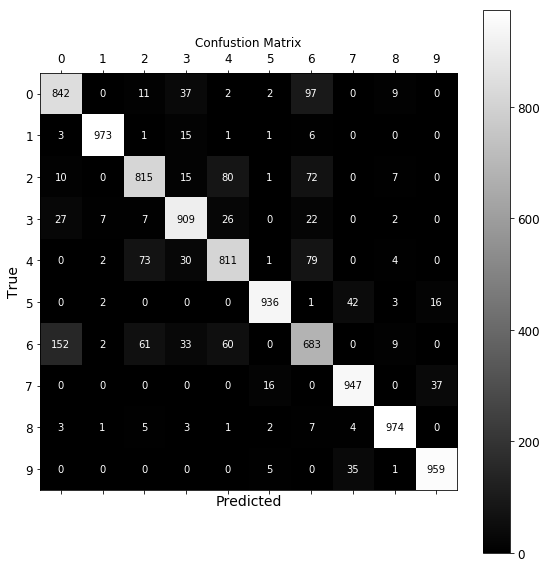

In [59]:
matrix_test = confusion_matrix(list(test_labels), predictions)
print("f1 score macro :",f1_score(test_labels, predictions, average='macro'))
plot_confusion_matrix(matrix_test, ["0","1","2","3","4","5","6","7","8","9"])

## Analysis

The performance of the CNN matched that of the MLP classifier. With the MLP classifier, we had the luxury to search the hyperparameter space and was able to improve the performance from 74% to 88% (f1_score). For the CNN I compared 2 different architectures and ranged between 84% to 88%. There are many more architectures to consider, within each many hyperparameters to fine-tune. 

So the three models created above the CNN and MLP(without autoencoded) perfomed similarly around 88% f1 score and the MLP(with autoencoder) performed slightly worse around 83% f1 score.

The following improvements can be made:

All three networks had minimal hyperparameter tuning the MLP focused on 3 hyperparameters whereas the CNN only compared a few different architectures. The autoencoder significantly increased the speed of training of the MLP classifier, so within the same time we used to search the hyperparameter space for the first MLP, we can search a greater range of parameters. 

Deeper networks. Each network can be trained using more neurons per layer and more layers, example the AlexNet CNN architecture had two more convolution layers than the one above. There need regularisation (Dropout or l2 etc) to make sure the deeper networks do not over fit the data.